In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets


import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

from IPython.display import clear_output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

---
# RL agent network:

In [2]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [3]:
class DecoderRNN(nn.Module):
    def __init__(
            self,
            embed_size, 
            vocab_size, 
            attention_dim, 
            encoder_dim, 
            decoder_dim,
            num_transforms=4,
            num_discrete_magnitude=11,
            seq_length=10,
            drop_prob=0.3
        ):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.num_transforms = num_transforms
        self.num_discrete_magnitude = num_discrete_magnitude
        self.seq_length = seq_length

        
        self.action_embd = nn.Embedding(3, embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)        
        
        self.fcn_transform = nn.Linear(decoder_dim,num_transforms)
        self.fcn_magnitude = nn.Linear(decoder_dim,num_discrete_magnitude)
        # self.fcn_proba = nn.Linear(decoder_dim,11)

        self.drop = nn.Dropout(drop_prob)
    

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c
    

    def forward(self, features):
                
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = self.seq_length
        batch_size = features.size(0)
        
        preds_transform = torch.zeros(batch_size, 2, seq_length, self.num_transforms).to(device)
        preds_magnitude = torch.zeros(batch_size, 2, seq_length, self.num_discrete_magnitude).to(device)
        # preds_proba     = torch.zeros(batch_size, 2, seq_length, 11).to(device)

        transform_action_id = torch.full((batch_size,), 0, dtype=torch.long, device=device)
        magnitude_action_id = torch.full((batch_size,), 1, dtype=torch.long, device=device)
        # proba_action_id     = torch.full((batch_size,), 2, dtype=torch.long, device=device)
        
        for x_num in range(2):
            for s in range(seq_length):
            # for s in tqdm(range(seq_length)):

                alpha, context = self.attention(features, h)
                action_embd = self.action_embd(transform_action_id)
                lstm_input = torch.cat((action_embd, context), dim=-1)
                h, c = self.lstm_cell(lstm_input, (h, c))
                output_transform = self.fcn_transform(self.drop(h))

                alpha, context = self.attention(features, h)
                action_embd = self.action_embd(magnitude_action_id)
                lstm_input = torch.cat((action_embd, context), dim=-1)
                h, c = self.lstm_cell(lstm_input, (h, c))
                output_magnitude = self.fcn_magnitude(self.drop(h))

                # alpha, context = self.attention(features, h)
                # action_embd = self.action_embd(proba_action_id)
                # lstm_input = torch.cat((action_embd, context), dim=-1)
                # h, c = self.lstm_cell(lstm_input, (h, c))
                # output_proba = self.fcn_proba(self.drop(h))
                
                preds_transform[:,x_num,s] = output_transform
                preds_magnitude[:,x_num,s] = output_magnitude
                # preds_proba    [:,x_num,s] = output_proba

        
        # return preds_transform, preds_magnitude, preds_proba
        return preds_transform, preds_magnitude

In [4]:
transformations_list = [
    ('brightness', (0, float('inf')), (0.1, 1.9)),
    ('contrast',   (0, float('inf')), (0.1, 1.9)),
    ('saturation', (0, float('inf')), (0.1, 1.9)),
    ('hue',        (-1, 1),           (-1, 1)   ),
]

In [5]:
decoder = DecoderRNN(
    embed_size=300,
    vocab_size=10,
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
    num_transforms=4,
    num_discrete_magnitude=11,
    seq_length=10
).to(device)

BATCH_SIZE = 256


In [6]:
features_1 = torch.rand((BATCH_SIZE, 4*4, 2048), device=device)
features_2 = torch.rand((BATCH_SIZE, 4*4, 2048), device=device)

preds_transform, preds_magnitude = decoder(features_1, features_2)
print(preds_transform.shape, preds_magnitude.shape)
del preds_transform, preds_magnitude

TypeError: DecoderRNN.forward() takes 2 positional arguments but 3 were given

---

# Dataset and Dataloader:

In [13]:
class Config:
    def __init__(
        self,
        dataset='cifar100',
        data_folder='dataset',
        batch_size=256,
        num_workers=8,
        size=32
    ):
        self.dataset = dataset
        self.data_folder = data_folder
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.size = size

opt = Config(
    dataset='cifar100',
    data_folder='dataset',
    batch_size=256,
    num_workers=8,
    size=32
)

In [14]:
def set_loader(opt: Config):
    # construct data loader
    if opt.dataset == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif opt.dataset == 'cifar100':
        mean = (0.5071, 0.4867, 0.4408)
        std = (0.2675, 0.2565, 0.2761)

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        # transforms.RandomResizedCrop(size=opt.size, scale=(0.2, 1.)),
        # transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])


    val_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    if opt.dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=opt.data_folder,
                                         transform=train_transform,
                                         download=True)
        val_dataset = datasets.CIFAR10(root=opt.data_folder,
                                       train=False,
                                       transform=val_transform)
    elif opt.dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root=opt.data_folder,
                                          transform=train_transform,
                                          download=True)
        val_dataset = datasets.CIFAR100(root=opt.data_folder,
                                        train=False,
                                        transform=val_transform)

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=opt.batch_size, 
        shuffle=(train_sampler is None),
        num_workers=opt.num_workers,
        # pin_memory=True, 
        sampler=train_sampler
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=256,
        shuffle=False,
        num_workers=1,
        # pin_memory=True
    )

    return train_loader, val_loader

In [15]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

def set_loader_contrastive(opt):
    # construct data loader
    if opt.dataset == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif opt.dataset == 'cifar100':
        mean = (0.5071, 0.4867, 0.4408)
        std = (0.2675, 0.2565, 0.2761)
    elif opt.dataset == 'path':
        mean = eval(opt.mean)
        std = eval(opt.std)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=opt.size, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    if opt.dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=opt.data_folder,
                                         transform=TwoCropTransform(train_transform),
                                         download=True)
    elif opt.dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root=opt.data_folder,
                                          transform=TwoCropTransform(train_transform),
                                          download=True)
    elif opt.dataset == 'path':
        train_dataset = datasets.ImageFolder(root=opt.data_folder,
                                            transform=TwoCropTransform(train_transform))
    else:
        raise ValueError(opt.dataset)

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
        num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)

    return train_loader

# opt = Config(
#     dataset='cifar10',
#     data_folder='dataset',
#     batch_size=16,
#     num_workers=4
# )

# train_loader = set_loader_contrastive(opt)

# (x1, x2), y = next(iter(train_loader))

---

# Resnet model:

In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        feature_map = out
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return feature_map, out


def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)


def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)


model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}


class LinearBatchNorm(nn.Module):
    """Implements BatchNorm1d by BatchNorm2d, for SyncBN purpose"""
    def __init__(self, dim, affine=True):
        super(LinearBatchNorm, self).__init__()
        self.dim = dim
        self.bn = nn.BatchNorm2d(dim, affine=affine)

    def forward(self, x):
        x = x.view(-1, self.dim, 1, 1)
        x = self.bn(x)
        x = x.view(-1, self.dim)
        return x


class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feature_map, inner_feat = self.encoder(x)
        # feat = F.normalize(self.head(feat), dim=1)
        projection_feat = self.head(inner_feat)
        return feature_map, inner_feat, projection_feat


class SupCEResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(SupCEResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        self.fc = nn.Linear(dim_in, num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))


class LinearClassifier(nn.Module):
    """Linear classifier"""
    def __init__(self, name='resnet50', num_classes=10):
        super(LinearClassifier, self).__init__()
        _, feat_dim = model_dict[name]
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, features):
        return self.fc(features)
    

# model = SupConResNet(name='resnet50').to(device)

# for x, y in tqdm(train_loader):
#     x = x.to(device)
#     feature_map, inner_feat, projection_feat = model(x)
#     feature_map = feature_map.permute(0, 2, 3, 1)
#     feature_map = feature_map.reshape(16, 16, 2048)
#     preds_transform, preds_magnitude, preds_proba = decoder(feature_map)

---
# Crtierion:

In [17]:
class InfoNCELoss(nn.Module):
    def __init__(self):
        super(InfoNCELoss, self).__init__()
        self.CE = nn.CrossEntropyLoss()


    def forward(self, z1, z2, batch_size, temperature):
        features = torch.cat((z1, z2), dim=0)

        labels = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0).to(device)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        features = F.normalize(features, dim=1)

        full_similarity_matrix = torch.matmul(features, features.T)

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = full_similarity_matrix[~mask].view(full_similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        logits = logits / temperature
        loss = self.CE(logits, labels)

        return full_similarity_matrix, logits, loss
    
# criterion = InfoNCELoss()

---
# Training:

In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [19]:
opt = Config(
    dataset='cifar10',
    data_folder='dataset',
    batch_size=64,
    num_workers=4
)

train_loader = set_loader_contrastive(opt)

Files already downloaded and verified


In [20]:
model = SupConResNet(name='resnet18').to(device)

criterion = InfoNCELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    # momentum=0.9,
    weight_decay=1e-4
)

In [23]:
del x1, x2, loss, _
torch.cuda.empty_cache()

NameError: name 'x1' is not defined

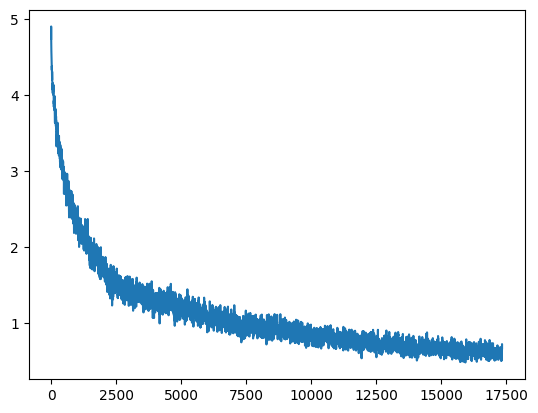

Epoch: 22 | Loss: 0.4724:  19%|█▊        | 145/782 [00:15<01:06,  9.61it/s]


KeyboardInterrupt: 

In [22]:
EPOCHS = 100
PLOT_EACH = 10

losses = []

for epoch in range(EPOCHS):
    tqdm_train_loader = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, ((x1, x2), y) in tqdm_train_loader:

        x1 = x1.to(device)
        x2 = x2.to(device)

        _, _, z1 = model(x1)
        _, _, z2 = model(x2)

        # x = torch.concatenate([x1, x2], dim=0)
        # _, _, z = model(x)
        # z1, z2 = z[:z.shape[0]//2], z[z.shape[0]//2:]

        _, _, loss = criterion(z1, z2, batch_size=x1.shape[0], temperature=0.07)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append( loss.item() )

        tqdm_train_loader.set_description(f'Epoch: {epoch+1} | Loss: {loss.item():.4f}')

        # print(torch.cuda.mem_get_info())

        del x1, x2, loss, _
        torch.cuda.empty_cache()

        if i % PLOT_EACH == 0:
            clear_output(True)
            plt.plot(smooth_curve(losses))
            plt.show()

        # print(torch.cuda.mem_get_info())

        # print('-'*20)

        # break
    # break


In [31]:
torch.save(model.state_dict(), 'contrastive_resnet18_20epochs.pt')

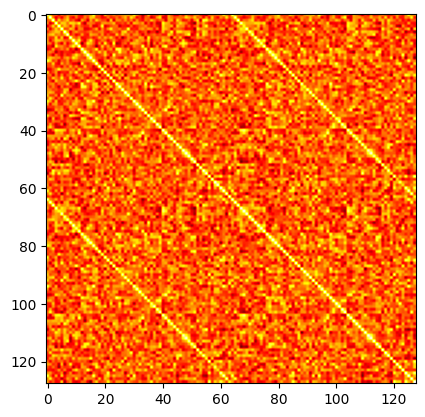

In [30]:
sim, _, _ = criterion(z1, z2, batch_size=z1.shape[0], temperature=0.07)
plt.imshow(sim.cpu().detach(), vmin=-1, vmax=1, cmap='hot') 